In [132]:
import os
import numpy as np
import matplotlib.pyplot as plt

from numpy.typing import NDArray
from mpl_toolkits.mplot3d import Axes3D
from pyod.utils.data import generate_data_clusters
from pyod.utils.utility import standardizer
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.base import BaseDetector
from pyod.models.combination import average, maximization
from sklearn.datasets import make_blobs
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from matplotlib.axes import Axes
from scipy.io import loadmat

In [133]:
OUT_DIR = 'images'
os.makedirs(OUT_DIR, exist_ok=True)

### Exercise 1

In [134]:
def generate_dataset(
        n: np.int64,
        n_dims: np.int64,
        coef: NDArray[np.float64],
        mean_x: NDArray[np.float64], 
        std_x: NDArray[np.float64],
        mean_y: np.float64,
        std_y: np.float64
) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
    X = np.random.normal(loc=mean_x, scale=std_x, size=(n, n_dims))
    eps = np.random.normal(loc=mean_y, scale=std_y, size=n)
    Y = np.hstack([X, np.ones(shape=(n, 1))]) @ coef + eps
    return X, Y

In [135]:
def compute_leverage_scores(X: NDArray[np.float64]) -> NDArray[np.float64]:
    n, d = X.shape
    U, _, _ = np.linalg.svd(X)
    h = np.zeros(n)
    for i in range(n):
        h[i] = U[i, :d].T @ U[i, :d]
    return h

In [136]:
def plot_leverage_datasets(
    datasets: list[tuple[np.ndarray, np.ndarray]],
    leverage_scores: list[np.ndarray],
    coef: np.ndarray,
    fig_path: str,
    titles: list[str] = None,
) -> None:
    n_datasets = len(datasets)
    n_cols = 2
    n_rows = (n_datasets + 1) // n_cols

    fig = plt.figure(figsize=(6 * n_cols, 5 * n_rows))

    n_dims = datasets[0][0].shape[1]
    is_2d = n_dims == 2

    for i, ((X, Y), h) in enumerate(zip(datasets, leverage_scores)):
        ax = fig.add_subplot(n_rows, n_cols, i + 1, projection="3d" if is_2d else None)

        idx_top = np.argsort(h)[-5:]

        if is_2d:
            x1, x2 = X[:, 0], X[:, 1]
            sc = ax.scatter(x1, x2, Y, c=h, cmap='viridis', s=30)
            ax.scatter(x1[idx_top], x2[idx_top], Y[idx_top],
                       facecolors='none', edgecolors='r', s=200, linewidths=2)

            x1_grid, x2_grid = np.meshgrid(
                np.linspace(x1.min(), x1.max(), 30),
                np.linspace(x2.min(), x2.max(), 30)
            )
            y_pred = (coef[0] * x1_grid + coef[1] * x2_grid + coef[2])
            ax.plot_surface(x1_grid, x2_grid, y_pred, alpha=0.3, color='gray', edgecolor='none')

            ax.set_xlabel("x₁")
            ax.set_ylabel("x₂")
            ax.set_zlabel("y")

        else:
            x = X[:, 0]
            sc = ax.scatter(x, Y, c=h, cmap='viridis', s=30)
            ax.scatter(x[idx_top], Y[idx_top],
                       facecolors='none', edgecolors='r', s=200, linewidths=2)

            x_line = np.linspace(x.min(), x.max(), 100)
            y_line = coef[0] * x_line + coef[1]
            ax.plot(x_line, y_line, color='gray', lw=2, label='Model prediction')

            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.legend()

        if titles is not None:
            ax.set_title(titles[i])
        else:
            ax.set_title(f"Dataset {i+1}")

        cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("Leverage")

    plt.tight_layout()
    plt.savefig(fig_path)
    plt.show()


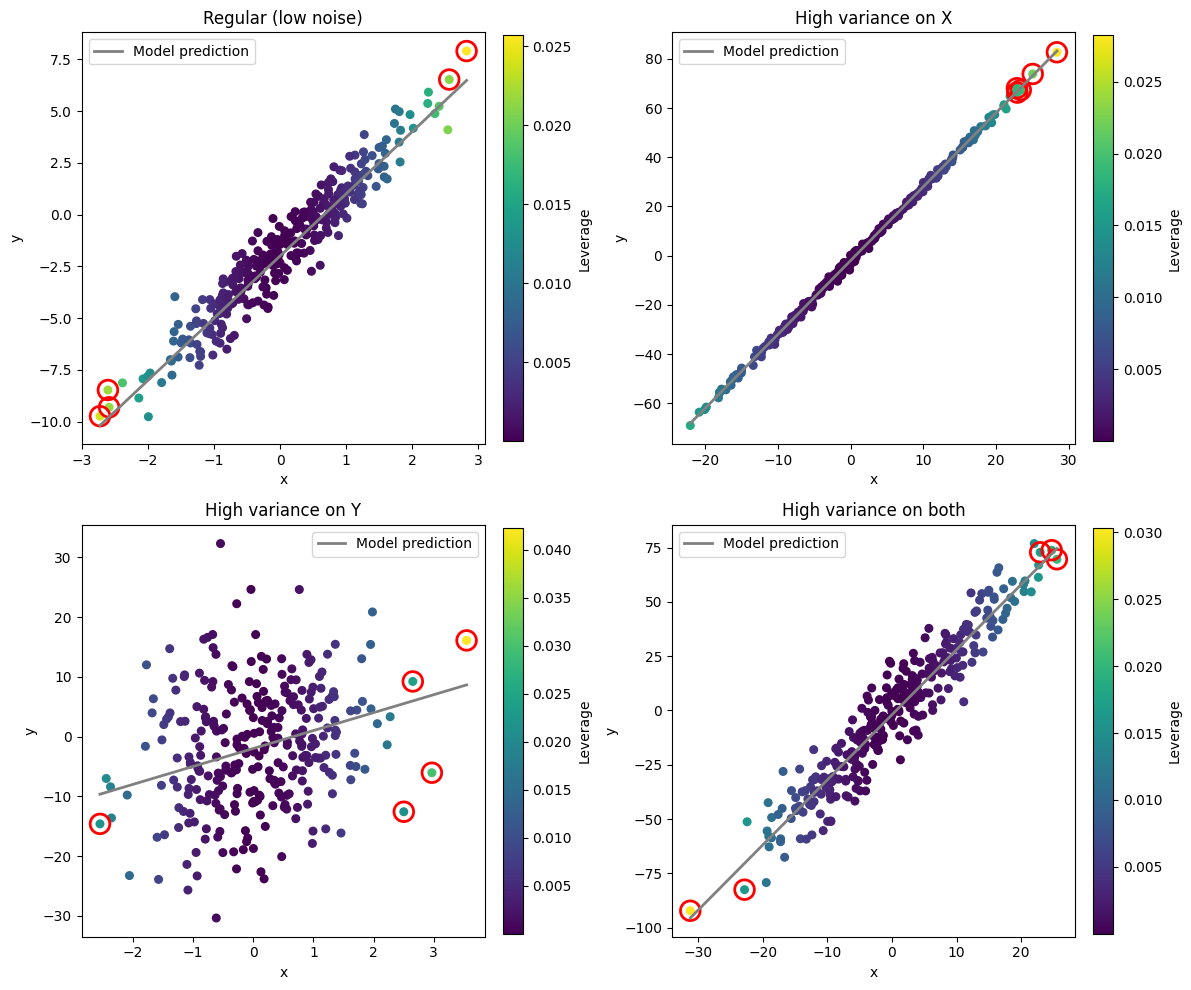

In [137]:
n = 300
n_dims = 1
means_x = np.array([[0.0], [0.0], [0.0], [0.0]])
stds_x = np.array([[1.0], [10.0], [1.0], [10.0]])
means_y = np.array([0.0, 0.0, 0.0, 0.0])
stds_y = np.array([1.0, 1.0, 10.0, 10.0])
coef = np.array([3.0, -2])

datasets_1d = [generate_dataset(n, n_dims, coef, mean_x, std_x, mean_y, std_y) 
            for mean_x, std_x, mean_y, std_y in zip(means_x, stds_x, means_y, stds_y)]
leverage_scores_1d = [compute_leverage_scores(dataset[0]) for dataset in datasets_1d]

titles = [
    "Regular (low noise)",
    "High variance on X",
    "High variance on Y",
    "High variance on both"
]
fig_path = os.path.join(OUT_DIR, 'ex1_1d.png')
plot_leverage_datasets(datasets_1d, leverage_scores_1d, coef, fig_path, titles)

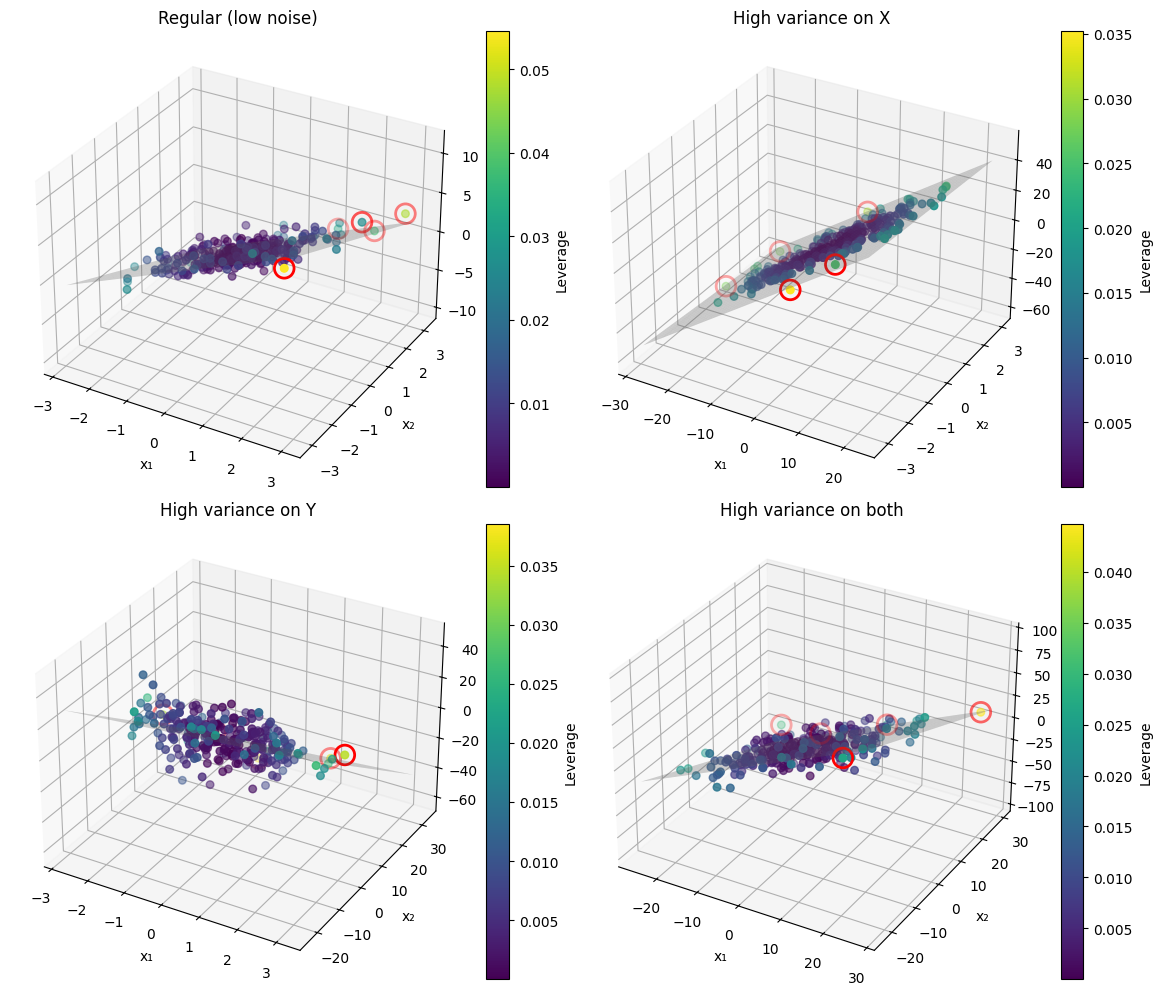

In [138]:
n = 300
n_dims = 2
means_x = np.array([[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]])
stds_x = np.array([[1.0, 1.0], [10.0, 1.0], [1.0, 10.0], [10.0, 10.0]])
means_y = np.array([0.0, 0.0, 0.0, 0.0])
stds_y = np.array([1.0, 1.0, 10.0, 10.0])
coef = np.array([2.0, -1.5, 0.5])


datasets_2d = [generate_dataset(n, n_dims, coef, mean_x, std_x, mean_y, std_y)
               for mean_x, std_x, mean_y, std_y in zip(means_x, stds_x, means_y, stds_y)]
leverage_scores_2d = [compute_leverage_scores(d[0]) for d in datasets_2d]

titles = [
    "Regular (low noise)",
    "High variance on X",
    "High variance on Y",
    "High variance on both"
]
fig_path = os.path.join(OUT_DIR, 'ex1_2d.png')
plot_leverage_datasets(datasets_2d, leverage_scores_2d, coef, fig_path, titles)


### Exercise 2

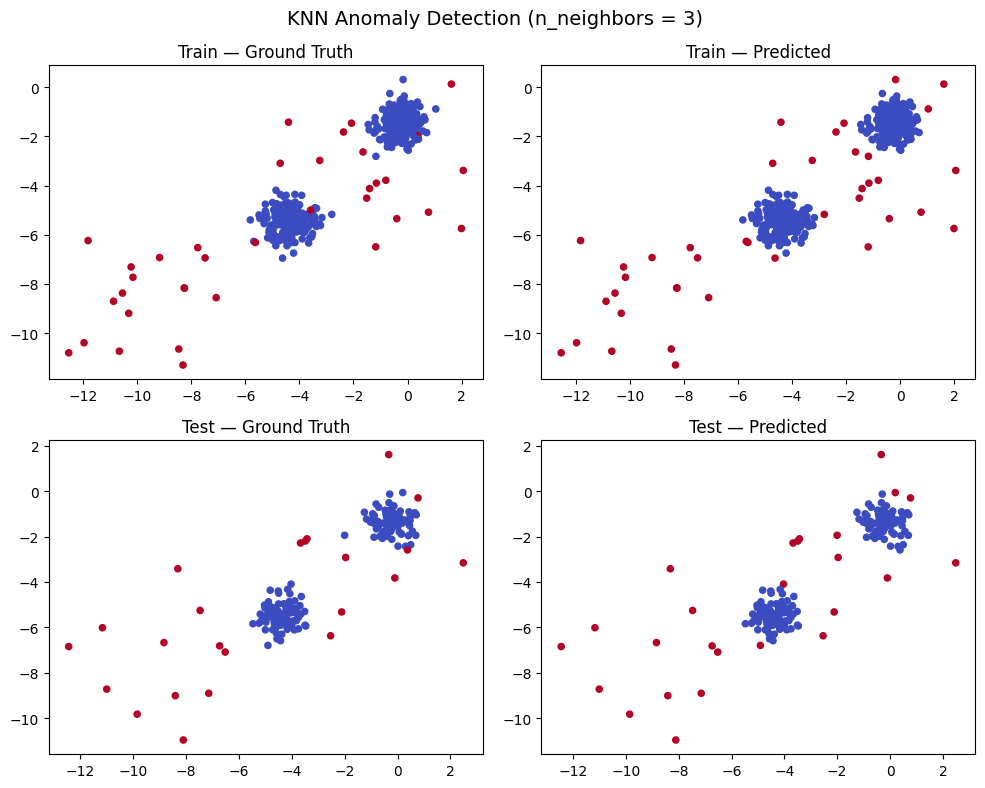

Train balanced accuracy for n_neighbors=3: 0.951
Test balanced accuracy for n_neighbors=3: 0.967


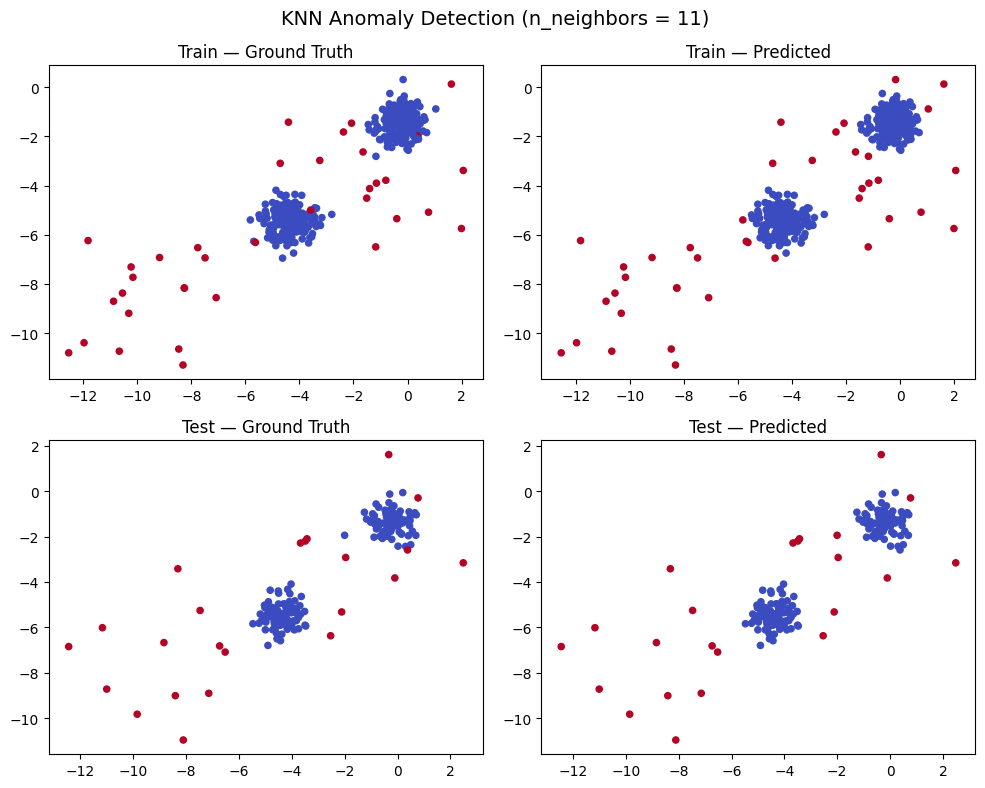

Train balanced accuracy for n_neighbors=11: 0.951
Test balanced accuracy for n_neighbors=11: 0.975


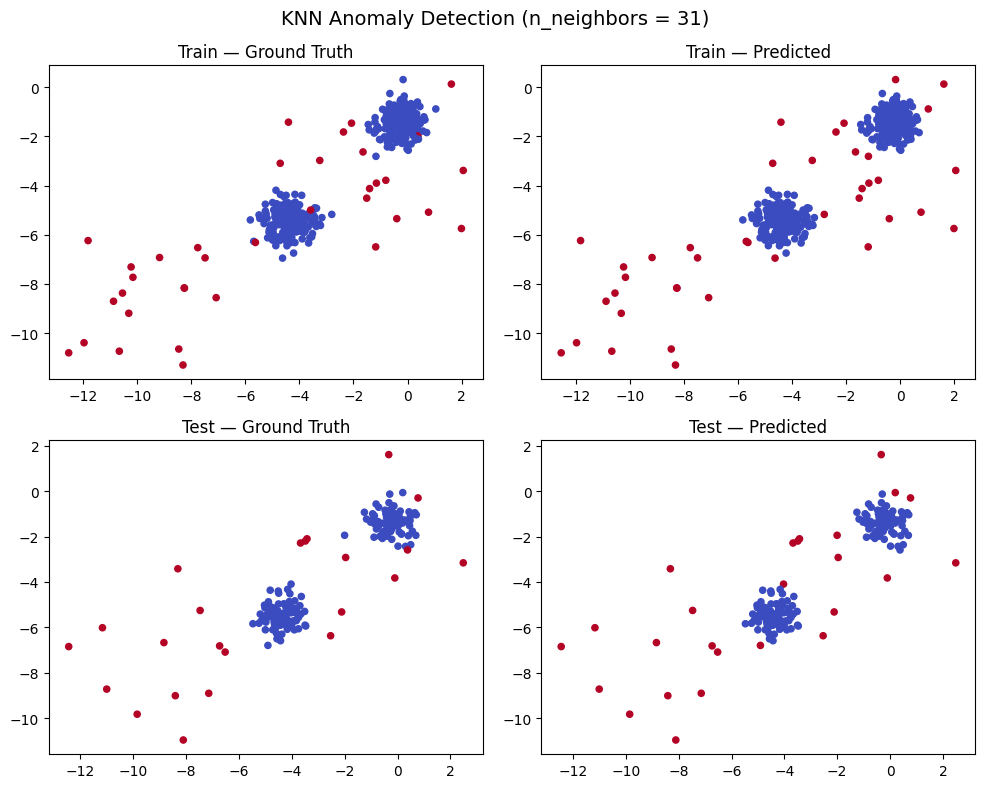

Train balanced accuracy for n_neighbors=31: 0.951
Test balanced accuracy for n_neighbors=31: 0.967


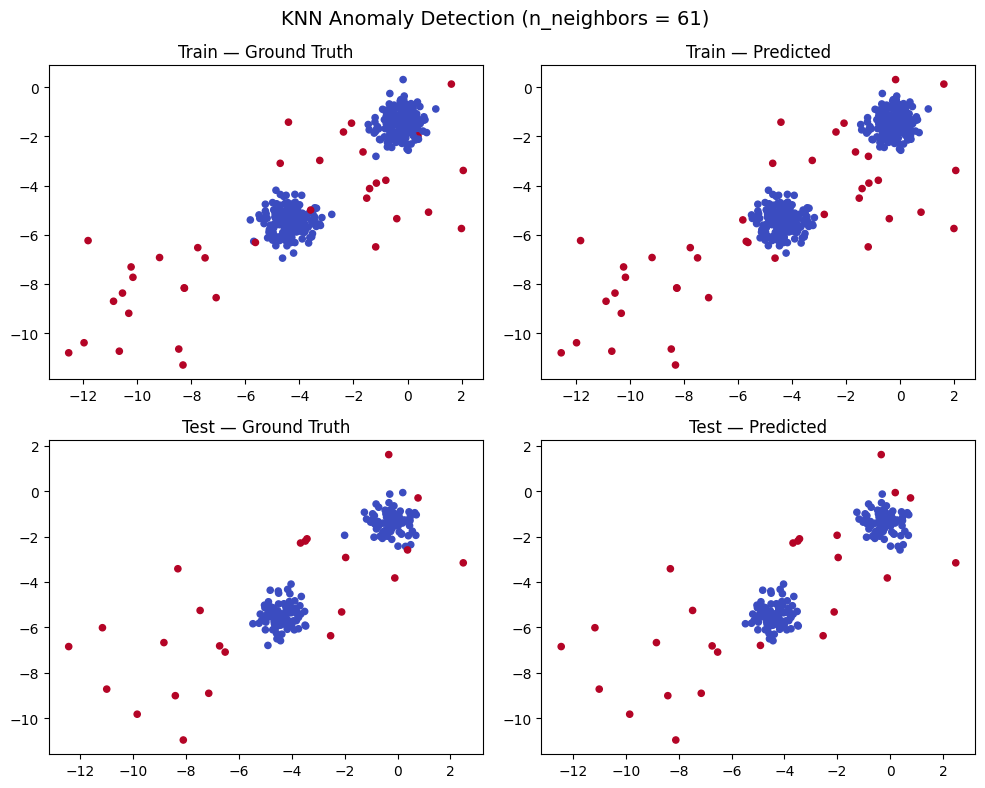

Train balanced accuracy for n_neighbors=61: 0.951
Test balanced accuracy for n_neighbors=61: 0.970


In [139]:
n_train = 400
n_test = 200
n_clusters = 2
contamination = 0.1 

X_train, X_test, y_train, y_test = generate_data_clusters(
    n_train=n_train,
    n_test=n_test,
    n_clusters=n_clusters,
    contamination=contamination)

neighbors_list = [3, 11, 31, 61]

for n_neighbors in neighbors_list:
    clf = KNN(n_neighbors=n_neighbors, contamination=contamination)
    clf.fit(X_train)
    
    y_train_pred = clf.labels_           
    y_test_pred = clf.predict(X_test)
    
    train_bal_acc = balanced_accuracy_score(y_train, y_train_pred)
    test_bal_acc = balanced_accuracy_score(y_test, y_test_pred)
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    
    axs[0, 0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', s=20)
    axs[0, 0].set_title("Train — Ground Truth")
    
    axs[0, 1].scatter(X_train[:, 0], X_train[:, 1], c=y_train_pred, cmap='coolwarm', s=20)
    axs[0, 1].set_title("Train — Predicted")
    
    axs[1, 0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', s=20)
    axs[1, 0].set_title("Test — Ground Truth")
    
    axs[1, 1].scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred, cmap='coolwarm', s=20)
    axs[1, 1].set_title("Test — Predicted")
    
    plt.suptitle(f"KNN Anomaly Detection (n_neighbors = {n_neighbors})", fontsize=14)
    plt.tight_layout()
    fig_path = os.path.join(OUT_DIR, f"ex2_k={n_neighbors}.png")
    plt.savefig(fig_path)
    plt.show()
    
    print(f"Train balanced accuracy for n_neighbors={n_neighbors}: {train_bal_acc:.3f}")
    print(f"Test balanced accuracy for n_neighbors={n_neighbors}: {test_bal_acc:.3f}")


### Exercise 3

In [140]:
def solve(X: NDArray, model: BaseDetector, ax: Axes, ax_title: str):
    model.fit(X)
    y_pred = model.labels_
    ax.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], c='lightblue', label='Inliers')
    ax.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], c='red', label='Outliers')
    ax.set_title(ax_title)
    ax.legend()
    ax.grid(True)

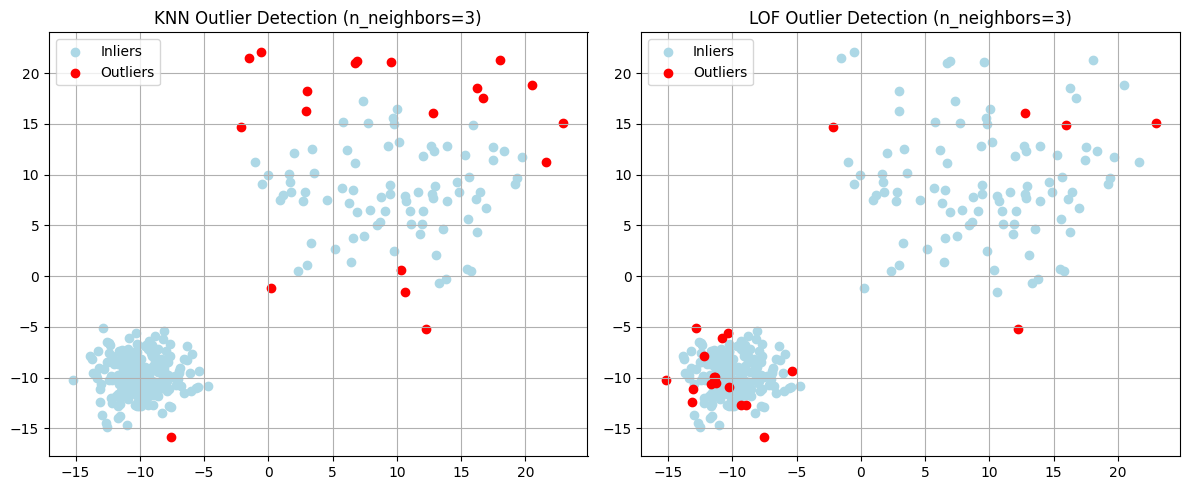

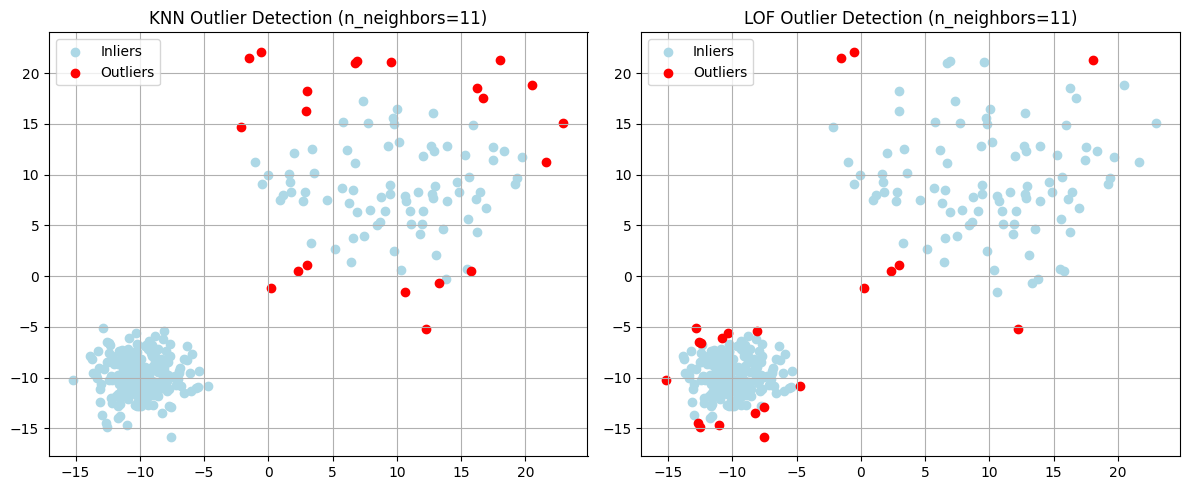

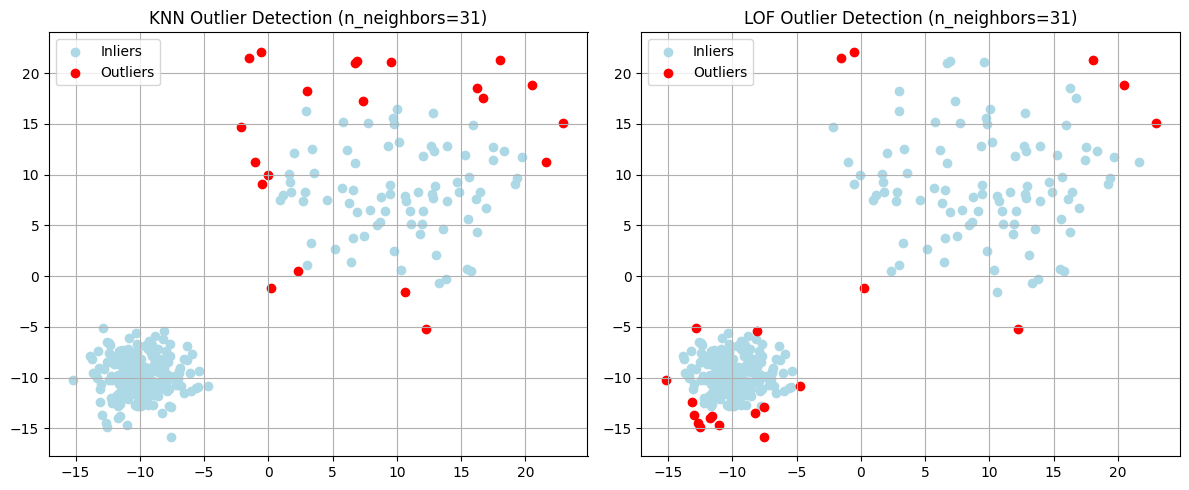

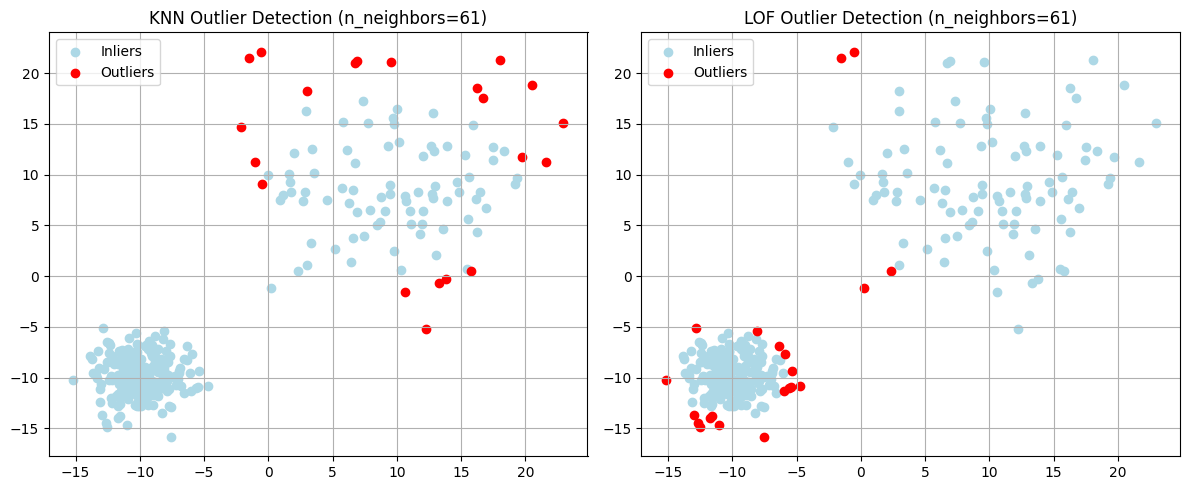

In [141]:
n_samples = [200, 100]
centers = [(-10, -10), (10, 10)]
cluster_std = [2, 6]
contamination = 0.07
neighbors_list = [3, 11, 31, 61]

X, _ = make_blobs(
    n_samples=n_samples,
    centers=centers,
    cluster_std=cluster_std)

for n_neighbors in neighbors_list:
    knn = KNN(contamination=contamination, n_neighbors=n_neighbors)
    lof = LOF(contamination=contamination, n_neighbors=n_neighbors)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    solve(X, knn, axes[0], f"KNN Outlier Detection (n_neighbors={n_neighbors})")
    solve(X, lof, axes[1], f"LOF Outlier Detection (n_neighbors={n_neighbors})")

    plt.tight_layout()
    fig_path = os.path.join(OUT_DIR, f"ex3_k={n_neighbors}.png")
    plt.savefig(fig_path)
    plt.show()

### Exercise 4

In [142]:
def solve(model: BaseDetector, X_train: NDArray, X_test: NDArray, y_train: NDArray, y_test:NDArray, fig_path: str) -> None:
    contamination = np.sum(y_train) / y_train.shape[0]

    neighbors_list = np.arange(31, 130, 10)
    train_scores = []
    test_scores = []

    for n_neighbors in neighbors_list:
        clf = model(n_neighbors=n_neighbors, contamination=contamination)
        clf.fit(X_train)
        
        train_scores.append(clf.decision_scores_)
        test_scores.append(clf.decision_function(X_test))
        
        y_train_pred = clf.labels_
        y_test_pred = clf.predict(X_test)
        
        ba_train = balanced_accuracy_score(y_train, y_train_pred)
        ba_test = balanced_accuracy_score(y_test, y_test_pred)
        
        print(f"(n_neighbors={n_neighbors}) → Train BA: {ba_train:.3f}, Test BA: {ba_test:.3f}")

    train_scores = np.array(train_scores).T
    test_scores = np.array(test_scores).T

    train_scores_norm = standardizer(train_scores)
    test_scores_norm = standardizer(test_scores)

    train_scores_avg = average(train_scores_norm)
    test_scores_avg = average(test_scores_norm)

    train_scores_max = maximization(train_scores_norm)
    test_scores_max = maximization(test_scores_norm)

    thresh_avg = np.quantile(train_scores_avg, 1 - contamination)
    thresh_max = np.quantile(train_scores_max, 1 - contamination)

    y_train_pred_avg = (train_scores_avg > thresh_avg).astype(int)
    y_test_pred_avg = (test_scores_avg > thresh_avg).astype(int)

    y_train_pred_max = (train_scores_max > thresh_max).astype(int)
    y_test_pred_max = (test_scores_max > thresh_max).astype(int)

    ba_train_avg = balanced_accuracy_score(y_train, y_train_pred_avg)
    ba_test_avg = balanced_accuracy_score(y_test, y_test_pred_avg)

    ba_train_max = balanced_accuracy_score(y_train, y_train_pred_max)
    ba_test_max = balanced_accuracy_score(y_test, y_test_pred_max)

    print("\n--- Ensemble Results ---")
    print(f"Average strategy:  Train BA={ba_train_avg:.3f}, Test BA={ba_test_avg:.3f}")
    print(f"Maximization strategy:  Train BA={ba_train_max:.3f}, Test BA={ba_test_max:.3f}")

    pca = PCA(n_components=3)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(131, projection='3d')
    sc = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2],
                    c=y_test, cmap='coolwarm', s=20)
    ax.set_title("Test Data (Ground Truth)")
    plt.colorbar(sc, ax=ax, label="Anomaly (1) / Normal (0)")

    ax2 = fig.add_subplot(132, projection='3d')
    sc2 = ax2.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2],
                    c=y_test_pred_avg, cmap='coolwarm', s=20)
    ax2.set_title("Test Data (Predicted Anomalies AVG)")
    plt.colorbar(sc2, ax=ax2, label="Predicted label")

    ax3 = fig.add_subplot(133, projection='3d')
    sc3 = ax3.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2],
                    c=y_test_pred_max, cmap='coolwarm', s=20)
    ax3.set_title("Test Data (Predicted Anomalies MAX)")
    plt.colorbar(sc3, ax=ax3, label="Predicted label")

    plt.tight_layout()
    plt.savefig(fig_path)
    plt.show()

----------Ensemble of KNN----------
(n_neighbors=31) → Train BA: 0.705, Test BA: 0.697
(n_neighbors=41) → Train BA: 0.723, Test BA: 0.727
(n_neighbors=51) → Train BA: 0.727, Test BA: 0.736
(n_neighbors=61) → Train BA: 0.732, Test BA: 0.746
(n_neighbors=71) → Train BA: 0.732, Test BA: 0.756
(n_neighbors=81) → Train BA: 0.740, Test BA: 0.757
(n_neighbors=91) → Train BA: 0.749, Test BA: 0.757
(n_neighbors=101) → Train BA: 0.749, Test BA: 0.757
(n_neighbors=111) → Train BA: 0.754, Test BA: 0.756
(n_neighbors=121) → Train BA: 0.754, Test BA: 0.768

--- Ensemble Results ---
Average strategy:  Train BA=0.736, Test BA=0.756
Maximization strategy:  Train BA=0.740, Test BA=0.767


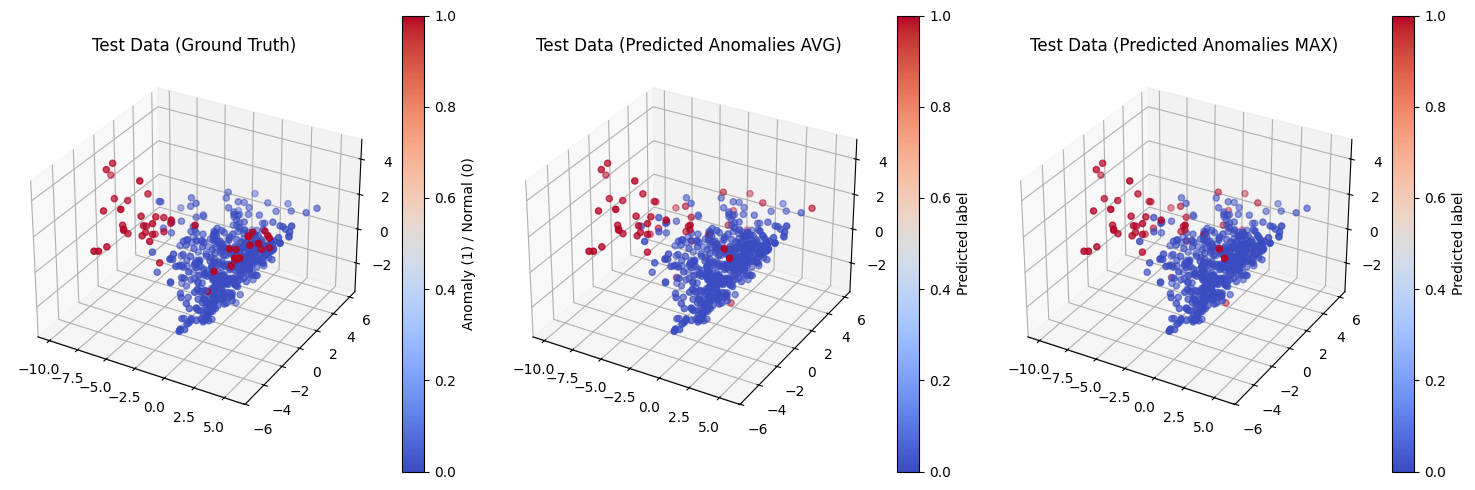

----------Ensemble of LOF----------
(n_neighbors=31) → Train BA: 0.564, Test BA: 0.542
(n_neighbors=41) → Train BA: 0.547, Test BA: 0.552
(n_neighbors=51) → Train BA: 0.564, Test BA: 0.552
(n_neighbors=61) → Train BA: 0.577, Test BA: 0.562
(n_neighbors=71) → Train BA: 0.591, Test BA: 0.594
(n_neighbors=81) → Train BA: 0.604, Test BA: 0.623
(n_neighbors=91) → Train BA: 0.630, Test BA: 0.624
(n_neighbors=101) → Train BA: 0.644, Test BA: 0.647
(n_neighbors=111) → Train BA: 0.674, Test BA: 0.649
(n_neighbors=121) → Train BA: 0.701, Test BA: 0.660

--- Ensemble Results ---
Average strategy:  Train BA=0.595, Test BA=0.617
Maximization strategy:  Train BA=0.630, Test BA=0.638


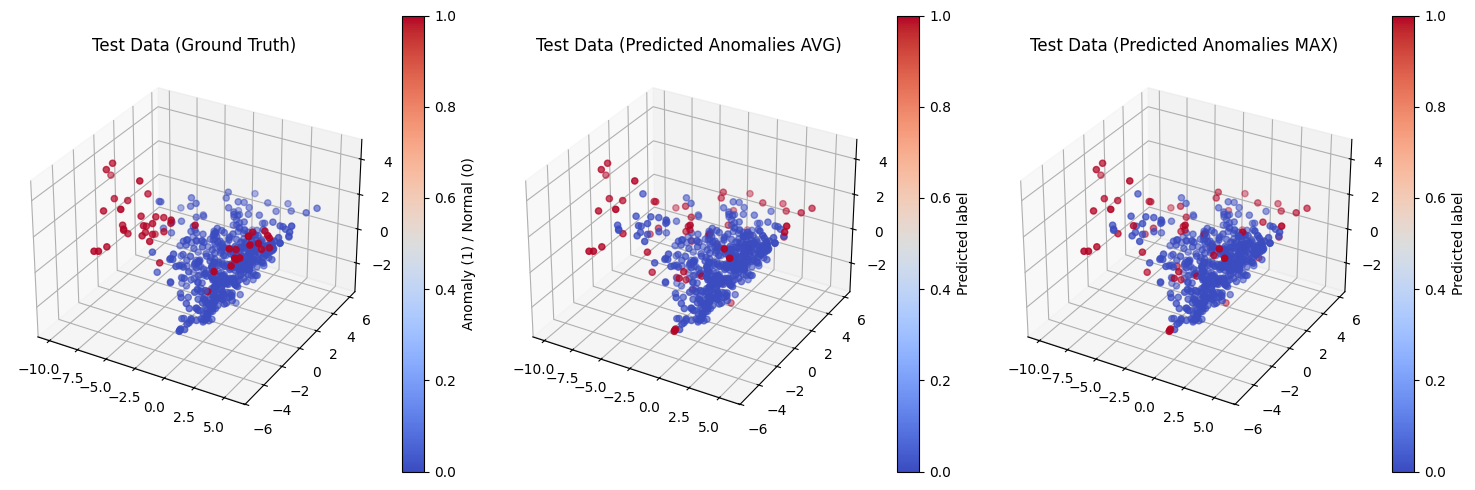

In [144]:
data = loadmat("cardio.mat")
X = data["X"]
y = data["y"].ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train = standardizer(X_train)
X_test = standardizer(X_test)

models = [KNN, LOF]
model_names = ['KNN', 'LOF']
for model, model_name in zip(models, model_names):
    print(f"----------Ensemble of {model_name}----------")
    fig_path = os.path.join(OUT_DIR, f"ex4_{model_name}.png")
    solve(model, X_train, X_test, y_train, y_test, fig_path)